# Tutorial of 10x Visium Spatial Gene and Protein on Tonsil

## Load the required packages

This notebook should be placed in the same directory as the **COSIE** folder.

In [1]:
import os
import torch
import scanpy as sc
import importlib
import numpy as np

In [2]:
from COSIE.data_preprocessing import load_data
from COSIE.utils import setup_seed
from COSIE.configure import get_default_config
from COSIE.COSIE_framework import COSIE_model
from COSIE.downstream_analysis import *

config = get_default_config()
setup_seed(config['training']['seed'])


## Load Data

The input data for this tutorial can be downloaded from: 

https://drive.google.com/drive/folders/11L8op1bMoIhbHmiOFHebhw6zvejjdAy8?usp=sharing

After downloading, data should be placed into a new folder named `Tonsil_10x` in the current working directory.


In [3]:
file_path = './Tonsil_10x'

In [4]:
adata1_rna = sc.read_h5ad(os.path.join(file_path, 'adata1_rna_tonsil_10x.h5ad'))
adata1_adt = sc.read_h5ad(os.path.join(file_path, 'adata1_adt_tonsil_10x.h5ad'))
adata2_rna = sc.read_h5ad(os.path.join(file_path, 'adata2_rna_tonsil_10x.h5ad'))
adata2_adt = sc.read_h5ad(os.path.join(file_path, 'adata2_adt_tonsil_10x.h5ad'))

In [5]:
adata1_rna.var_names_make_unique()
adata2_adt.var_names_make_unique()

In [6]:
adata1_he = sc.AnnData(X=adata1_adt.obsm['UNI_feature'])
adata2_he = sc.AnnData(X=adata2_adt.obsm['UNI_feature'])
adata1_he.obsm['spatial'] = adata1_adt.obsm['spatial'].copy()
adata2_he.obsm['spatial'] = adata2_adt.obsm['spatial'].copy()
adata1_he, adata2_he

(AnnData object with n_obs × n_vars = 234983 × 2048
     obsm: 'spatial',
 AnnData object with n_obs × n_vars = 184956 × 2048
     obsm: 'spatial')

## Define the dictionary structure for input data


- `data_dict` is a Python dictionary that maps each modality name (e.g., `'RNA'`, `'Protein'`) to a list of `AnnData` objects, where:

    - Each element in the list represents one tissue section.
    - Each `AnnData` must include:
      - `.X` — expression or intensity matrix  
      - `.obs` — per-cell obs data  
      - `.var` — per-feature var data  
      - `.obsm['spatial']` — spatial coordinates  
    - If a modality is missing in a section, use `None` as a placeholder.


Here we pretend **Protein is missing in Section1**, and **RNA is missing in Section2**

In [7]:
data_dict = {
        'HE': [adata1_he, adata2_he],
        'RNA': [adata1_rna, None],
        'Protein': [None, adata2_adt],
    }

The constructed `data_dict` will be processed by `load_data` function, which returns processed feature matrices and spatial coordinates. 

`n_comps` is the number of PCA components to compute, and `metacell` indicates whether to merge each 2×2 spatial grid of cells into a metacell to reduce memory usage and improve speed.  

In [8]:
feature_dict, spatial_loc_dict, data_dict_processed = load_data(data_dict, n_comps=50, metacell = True)

Combine adjacent 4 cells into metacell to save memory and speed up computation
-------- Processing shared modality HE across sections --------
Running Harmony for HE


2025-08-08 12:29:34,420 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-08-08 12:29:41,709 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-08-08 12:29:42,432 - harmonypy - INFO - Iteration 1 of 10
2025-08-08 12:30:18,651 - harmonypy - INFO - Iteration 2 of 10
2025-08-08 12:30:53,294 - harmonypy - INFO - Converged after 2 iterations


-------- Processing unique modality RNA for section 1 --------
-------- Processing unique modality Protein for section 2 --------
Extracting spatial location for section 1
Extracting spatial location for section 2


## Specify the Linkage Indicator

COSIE requires an **indicator dictionary** to specify the cross-section linkage used during training. The following ```('s1', 's2'): [('RNA', 'Protein')]``` indicates that the RNA–Protein linkage between section s1 and s2 will be used as the cross-section linkage information.

In [9]:
Linkage_indicator = {
        ('s1', 's2'): [ ('RNA', 'Protein')]
    }


## Define COSIE model and perform integration

After training, embeddings will be saved to `file_path` in `.npy` format for each section independently.

In [10]:
model = COSIE_model(config, feature_dict)
optimizer = torch.optim.Adam(model.parameters(), lr=config['training']['lr'])
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

All modalities: ['HE', 'RNA', 'Protein']
-------- Encoder description --------
Encoder [HE]: Input 50 → Hidden [256, 128]
Encoder [RNA]: Input 50 → Hidden [256, 128]
Encoder [Protein]: Input 20 → Hidden [256, 128]
-------- Dual prediction module description --------
Predictor [HE → RNA]: [128, 512, 512, 128]
Predictor [RNA → HE]: [128, 512, 512, 128]
Predictor [HE → Protein]: [128, 512, 512, 128]
Predictor [Protein → HE]: [128, 512, 512, 128]
Using device: cuda:0


During training, when both `n_x = 1` and `n_y = 1`, the model runs in full-graph training mode. When either `n_x` or `n_y` is greater than 1, the model will switch to subgraph training mode and partitions each section into a grid of `n_x × n_y` subregions.

In [11]:
final_embeddings = model.train_model(file_path, config, optimizer, device, feature_dict, spatial_loc_dict, 
                                     data_dict_processed, Linkage_indicator, n_x=2, n_y=2)

-------- Running Sub-graph training mode, n_x is 2, n_y is 2 --------
Splitting section [s1] into 2 x 2 subgraphs
Splitting HE in section s1...
Splitting RNA in section s1...
Splitting section [s2] into 2 x 2 subgraphs
Splitting HE in section s2...
Splitting Protein in section s2...
Computing linkage between [RNA] (s1-0) and [Protein] (s2-0)
Number of overlapping features: 18
Computing linkage between [RNA] (s1-0) and [Protein] (s2-1)
Number of overlapping features: 18
Computing linkage between [RNA] (s1-0) and [Protein] (s2-2)
Number of overlapping features: 18
Computing linkage between [RNA] (s1-0) and [Protein] (s2-3)
Number of overlapping features: 18
Computing linkage between [RNA] (s1-1) and [Protein] (s2-0)
Number of overlapping features: 18
Computing linkage between [RNA] (s1-1) and [Protein] (s2-1)
Number of overlapping features: 18
Computing linkage between [RNA] (s1-1) and [Protein] (s2-2)
Number of overlapping features: 18
Computing linkage between [RNA] (s1-1) and [Protein

Training Epochs: 100%|████████████████████████████████████████████████████████████████| 600/600 [03:35<00:00,  2.78it/s]


 Running Evaluation...
Missing modality [Protein] in Section [s1]
Using predictor [HE → Protein] to recover missing embedding...
Mapping metacell embedding back to original cells for Section s1 using modality [HE]
Missing modality [RNA] in Section [s2]
Using predictor [HE → RNA] to recover missing embedding...
Mapping metacell embedding back to original cells for Section s2 using modality [HE]
All embeddings have been saved to ./Tonsil_10x


## Joint clustering and visualization

Joing tissue segmentation based on COSIE's embedding

Perform joint clustering...


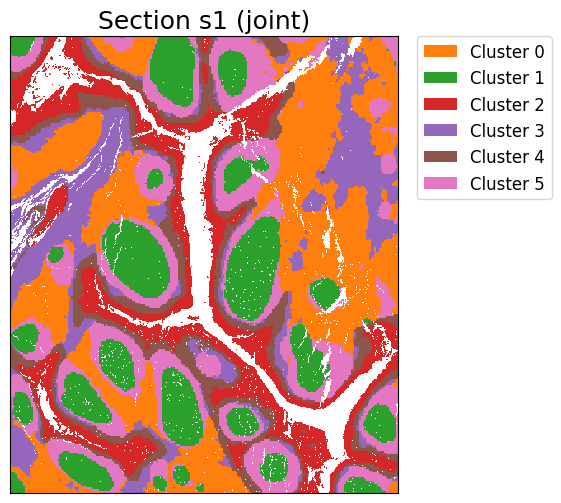

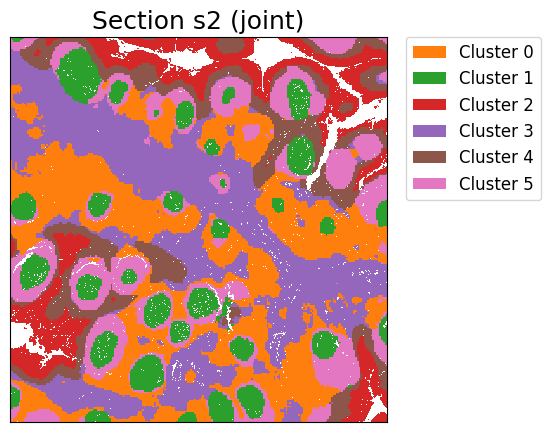

In [12]:
cluster_label = cluster_and_visualize_superpixel(final_embeddings, 
                                                 data_dict,
                                                 n_clusters=6,
                                                 offset = True,
                                                 mode="joint", 
                                                 vis_basis="spatial",  
                                                 figscale = 80)

## Prediction of missing modalities

COSIE recovers missing modality data for each section by leveraging feature similarity within its integrated embedding space.

Users can specify the **section** to be predicted, the **modality** to predict, the **target molecules**, and one or more **source sections** from which observed data will serve as the reference.

Setting `accelerate = True` enables COSIE to first perform PCA on the integrated embedding.


##### Protein prediction for Section 1 

In [13]:
adata1_protein_predicted = perform_prediction(data_dict,
    final_embeddings,
    target_section = 's1',
    target_modality = 'Protein',
    K_num=500,
    target_molecules='All',
    accelerate=True,
    )

Performing joint PCA on all embeddings for acceleration...
PCA completed. All embeddings reduced to 50 dimensions.
  Section s1: PCA embedding shape = (234983, 50)
  Section s2: PCA embedding shape = (184956, 50)
Using modality [HE] in section [s1] as spatial/obs reference
[Protein] exists in ['s2'], which will be used as source data section


In [14]:
adata1_protein_predicted_norm = create_normalized_adata(adata1_protein_predicted)
adata1_adt_norm = create_normalized_adata(adata1_adt)

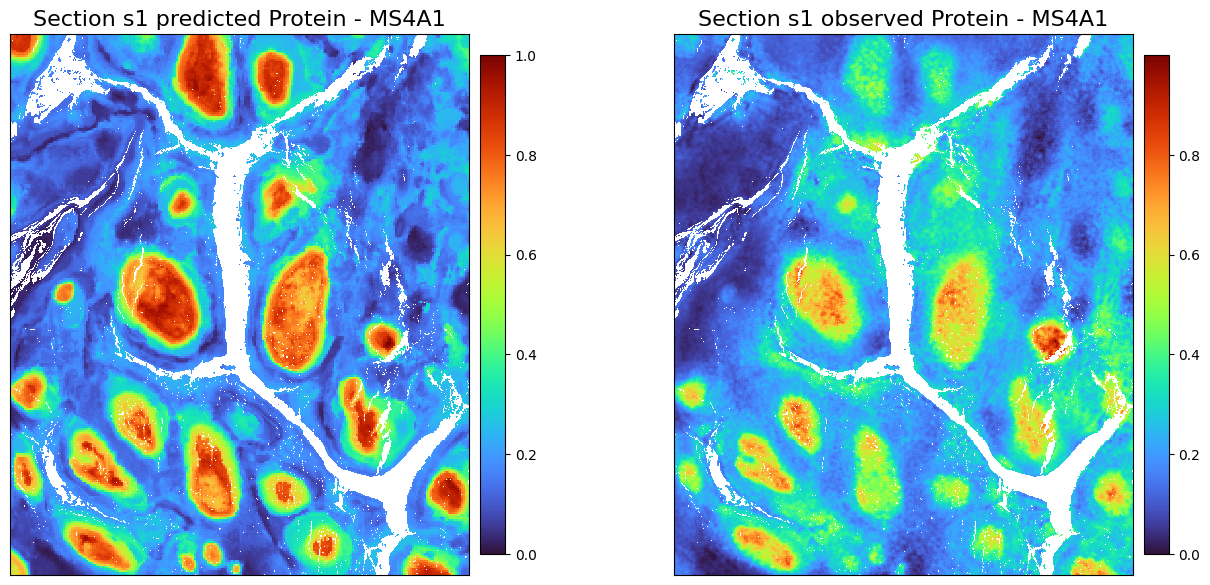

In [15]:
chosed_protein = 'MS4A1'
plot_marker_comparison_superpixel(chosed_protein, 
                                  adata1_protein_predicted_norm, 
                                  adata1_adt_norm, 
                                  'Section s1 predicted Protein', 
                                  'Section s1 observed Protein',
                                  offset=True,
                                  figscale = 60,)

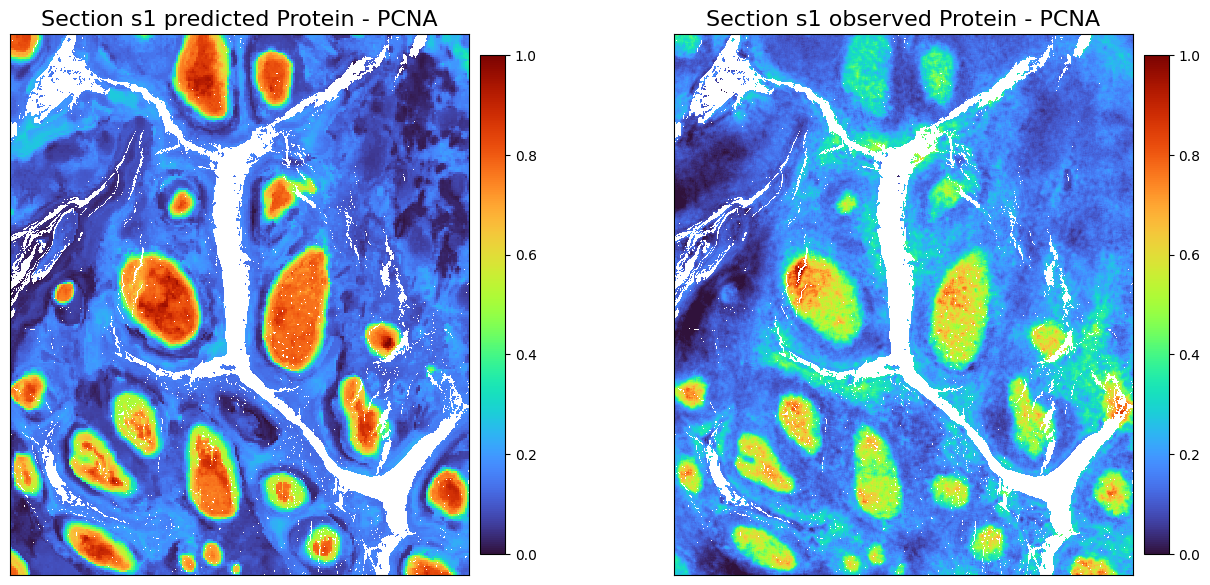

In [16]:
chosed_protein = 'PCNA'
plot_marker_comparison_superpixel(chosed_protein, 
                                  adata1_protein_predicted_norm, 
                                  adata1_adt_norm, 
                                  'Section s1 predicted Protein', 
                                  'Section s1 observed Protein',
                                  offset=True,
                                  figscale = 60,)

##### Gene prediction for Section 2

In [17]:
adata2_rna_predicted = perform_prediction(data_dict,
    final_embeddings,
    target_section = 's2',
    target_modality = 'RNA',
    K_num=500,
    target_molecules=['BCL6','CD38'],
    accelerate=True,
    )

Performing joint PCA on all embeddings for acceleration...
PCA completed. All embeddings reduced to 50 dimensions.
  Section s1: PCA embedding shape = (234983, 50)
  Section s2: PCA embedding shape = (184956, 50)
Using modality [HE] in section [s2] as spatial/obs reference
[RNA] exists in ['s1'], which will be used as source data section


In [18]:
adata2_rna_predicted_norm = create_normalized_adata(adata2_rna_predicted)
adata2_rna_norm = create_normalized_adata(adata2_rna)

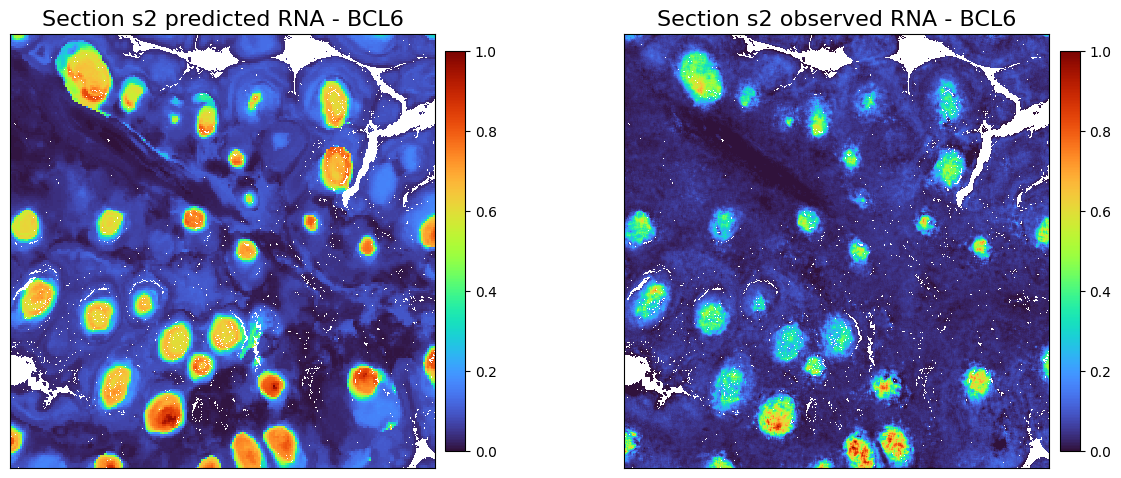

In [19]:
chosed_gene = 'BCL6'
plot_marker_comparison_superpixel(chosed_gene, 
                       adata2_rna_predicted_norm, 
                       adata2_rna_norm, 
                       'Section s2 predicted RNA', 
                       'Section s2 observed RNA',
                        offset = True,
                        figscale = 60,)


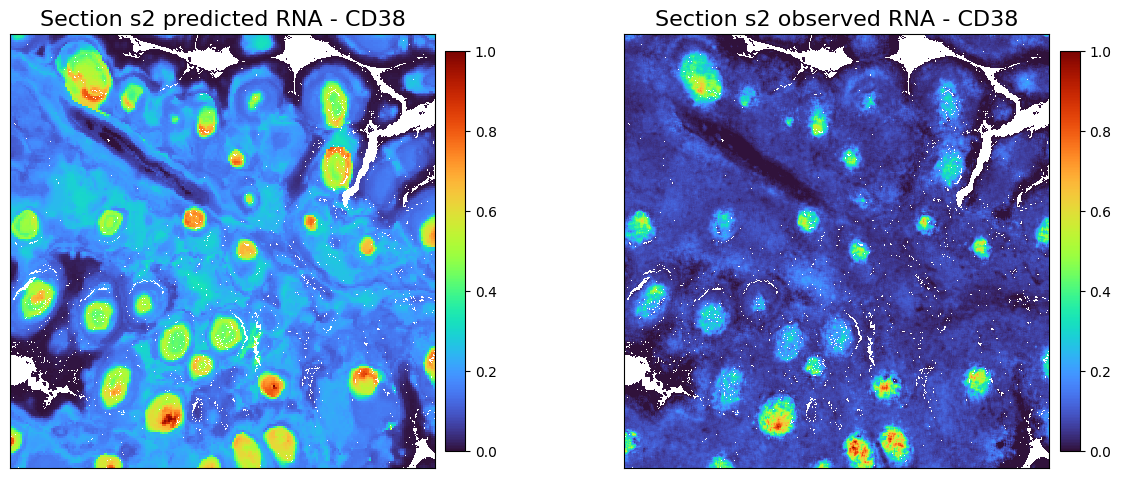

In [20]:
chosed_gene = 'CD38'
plot_marker_comparison_superpixel(chosed_gene, 
                       adata2_rna_predicted_norm, 
                       adata2_rna_norm, 
                       'Section s2 predicted RNA', 
                       'Section s2 observed RNA',
                        offset = True,
                        figscale = 60,)
